In [1]:
import sys
sys.path.insert(0, '/home/jonathan/Documents/mi3-balance/build/python')

import drjit as dr
import mitsuba as mi
from drjit.auto import Float, UInt, Bool

mi.set_variant('cuda_ad_rgb')

In [2]:
# !python3 /home/jonathan/Documents/mi3-balance/scripts/resources/cbox-tessellated/generate_cbox.py 5


In [3]:
from radiosity_sh import RadianceCacheMiSH
from radiosity_sh import compute_loss as compute_loss_sh

scene = mi.load_file("/home/jonathan/Documents/mi3-balance/scripts/resources/cbox-tessellated/cbox.xml")
# scene = mi.load_file("/home/jonathan/Documents/mi3-balance/scripts/resources/cbox-tessellated/cbox-rgb.xml")
# scene = mi.load_file("/home/jonathan/Documents/mi3-balance/resources/data/scenes/matpreview/matpreview.xml")

sh_order = 0
radiance_cache = RadianceCacheMiSH(scene, sh_order, fit_Nquad=128, fit_spp=64)

Fitting spherical harmonics to scene...


100%|██████████| 8/8 [00:06<00:00,  1.17it/s]

Fitting complete.


In [4]:
from radiosity_sh import SceneSurfaceSampler

scene_sampler = SceneSurfaceSampler(scene)

In [5]:
from radiosity import RadianceCacheMITSUBA
from radiosity import compute_loss as compute_loss_mi

radiance_cache_exact = RadianceCacheMITSUBA(scene, 256, 128)

In [6]:
colors = {
    'white': [0.9, 0.7, 0.6],
    'box': [0.5, 0.3, 0.9],
    'red': [0.6, 0.1, 0.1],
    'green': [0.1, 0.4, 0.1],
    'light': [0.9, 0.7, 0.7]
}

mesh_materials = ['light', 'white', 'white', 'white', 'green', 'red', 'box', 'box']

In [7]:
from principled_bsdf import Principled, Diffuse

bsdf_train = Principled(specular=0.0)   # TODO: should `specular` also be a trainable parameter?

for idx, mesh in enumerate(scene.shapes()):
    if not(mesh.is_mesh()):
        continue
    bsdf_train.initialize_mesh_attributes(mesh, [0.5, 0.5, 0.5], 0.0, 0.0)


# for idx, (mesh, material) in enumerate(zip(scene.shapes(), mesh_materials)):
#     if not(mesh.is_mesh()):
#         continue
#     bsdf_train.initialize_mesh_attributes(mesh, colors[material], 0.0, 0.0)

# TODO
# bsdf_train = Diffuse()

In [8]:
NUM_GEO_SAMPLES = 1 << 20 # 1 << 14
NUM_WI_DIRECTIONS = 256

In [9]:
# TODO: check equivalence between `Principled(alpha={0.0, 1.0}, metallic=False)` and `Diffuse()`

# compute_loss_mi(scene_sampler, radiance_cache_exact, Principled(specular=0.0), NUM_GEO_SAMPLES, NUM_WI_DIRECTIONS, 0)
# compute_loss_mi(scene_sampler, radiance_cache_exact, Diffuse(), NUM_GEO_SAMPLES, NUM_WI_DIRECTIONS, 0)
compute_loss_sh(scene_sampler, radiance_cache, Principled(specular=0.0), NUM_GEO_SAMPLES, NUM_WI_DIRECTIONS, 0)
# compute_loss_sh(scene_sampler, radiance_cache, Diffuse(), NUM_GEO_SAMPLES, NUM_WI_DIRECTIONS, 0)

[0.463204]

In [10]:
# from principled_bsdf import visualize_textures

# visualize_textures(scene)

In [11]:
from time import time

params = mi.traverse(scene)
# keys = [key for key in params.keys() if "vertex_bsdf" in key]
keys = [key for key in params.keys() if "vertex_bsdf_base_color" in key]    # TODO
opt = mi.ad.Adam(lr=0.05)
for key in keys:
    dr.enable_grad(params[key])
    opt[key] = params[key]
    params.update(opt)

losses = []
for it in range(100):
    time1 = time()

    # Evaluate the objective function for the current BSDF params
    loss = compute_loss_sh(scene_sampler, radiance_cache, bsdf_train, 
        NUM_GEO_SAMPLES, NUM_WI_DIRECTIONS, it)
    # loss = compute_loss_mi(scene_sampler, radiance_cache_exact, bsdf_train, 
    #     NUM_GEO_SAMPLES, NUM_WI_DIRECTIONS, it)

    # Backpropagate through the rendering process
    dr.backward(loss)

    # Optimizer: take a gradient descent step
    opt.step()

    # Post-process the optimized parameters to ensure legal color values.
    for key in keys:
        opt[key] = dr.clip(opt[key], 0.0, 1.0)

    # Update the scene state to the new optimized values
    params.update(opt)

    losses.append(loss.numpy())
    time2 = time()
    print(f"Iteration {1+it:03d} [{time2 - time1:2f}]: Loss = {loss}")

Iteration 001 [0.177615]: Loss = [0.463204]
Iteration 002 [0.170008]: Loss = [0.38133]
Iteration 003 [0.166554]: Loss = [0.298774]
Iteration 004 [0.170609]: Loss = [0.240746]
Iteration 005 [0.169394]: Loss = [0.184185]
Iteration 006 [0.164029]: Loss = [0.133588]
Iteration 007 [0.168646]: Loss = [0.101426]
Iteration 008 [0.170203]: Loss = [0.0673598]
Iteration 009 [0.169887]: Loss = [0.0513778]
Iteration 010 [0.171684]: Loss = [0.0373592]
Iteration 011 [0.171037]: Loss = [0.0245346]
Iteration 012 [0.170657]: Loss = [0.0241658]
Iteration 013 [0.170794]: Loss = [0.0257169]
Iteration 014 [0.171279]: Loss = [0.023212]
Iteration 015 [0.170539]: Loss = [0.0242587]
Iteration 016 [0.168901]: Loss = [0.023962]
Iteration 017 [0.169330]: Loss = [0.0218132]
Iteration 018 [0.170348]: Loss = [0.0263787]
Iteration 019 [0.171381]: Loss = [0.0235596]
Iteration 020 [0.170098]: Loss = [0.0234798]
Iteration 021 [0.169805]: Loss = [0.0251368]
Iteration 022 [0.170386]: Loss = [0.0231402]
Iteration 023 [0.171

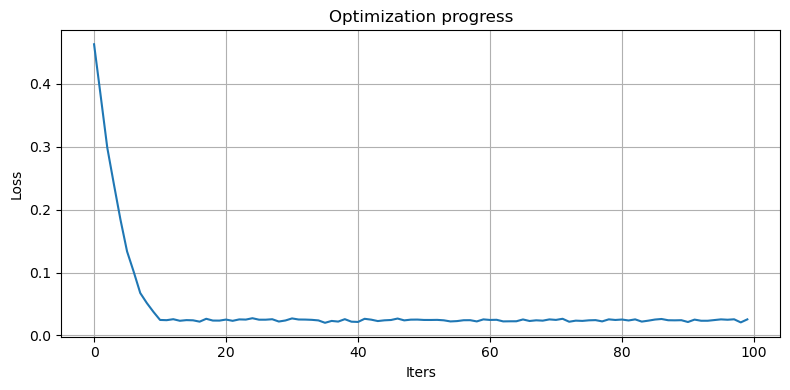

In [12]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(8,4))
plt.title("Optimization progress")
plt.plot(np.array(losses))
plt.xlabel("Iters")
plt.ylabel("Loss")
plt.grid()
plt.tight_layout()

In [13]:
from principled_bsdf import visualize_textures

visualize_textures(scene)

[polyscope] Backend: openGL3_glfw -- Loaded openGL version: 3.3.0 NVIDIA 550.120
